In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is i

In [ ]:
from datasets import load_dataset, concatenate_datasets
from huggingface_hub import login
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter

login("") # Insert HF API key here
ro_math_bac_set = load_dataset('cosmadrian/romath', 'bac')
ro_math_comp_set = load_dataset('cosmadrian/romath', 'comps')
ro_math_synthethic_set = load_dataset('cosmadrian/romath', 'synthetic')

In [11]:
ro_math_bac_set_combined = concatenate_datasets([ro_math_bac_set['train'], ro_math_bac_set['test']])

In [12]:
ro_math_comp_set_combined = concatenate_datasets([ro_math_comp_set['train'], ro_math_comp_set['test']])
ro_math_synthethic_set_combined = concatenate_datasets([ro_math_synthethic_set['train'], ro_math_synthethic_set['test']])

EDA: Observing the domain distribution in the dataset
To make it easier, we have combined the train and test split to get the total number of samples belonging to a certain domain in our set

In [161]:
class DatasetAnalyzer:
  """
    A class that helps with EDA.
    Currently supports:
    - Computing domain frequency distributions for each dataset subset (bac, comps, synthetic).
  """

  DOMAIN_COLUMN_NAME = 'domain'

  def __init__(self, ro_math_bac_set, ro_math_comp_set, ro_math_syntethic_set):
    self.data_subsets = {
        'bac': ro_math_bac_set,
        'comps': ro_math_comp_set,
        'synthetic': ro_math_syntethic_set
    }


  def get_domain_distribution(self, subset: str):
    if subset not in self.data_subsets:
      raise ValueError("Invalid data subset")

    analyzed_subset = self.data_subsets[subset]
    return dict(Counter(analyzed_subset[self.DOMAIN_COLUMN_NAME]))


In [162]:
class DatasetVisualizer(DatasetAnalyzer):

  """
    Inherits from DatasetAnalyzer. Adds visualization methods for domain distributions
    across BAC, COMP, and SYNTHETIC subsets.
  """

  def __init__(self, ro_math_bac_set, ro_math_comp_set, ro_math_syntethic_set):
    super().__init__(ro_math_bac_set, ro_math_comp_set, ro_math_syntethic_set)

  def visualize_domain_distributions(self):
    overall_domain_distributions = [self.get_domain_distribution(subset) for subset in self.data_subsets]

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    bar_width = 0.6
    plot_colors = ['b', 'g', 'r']

    for idx, (subset, color) in enumerate(zip(self.data_subsets, plot_colors)):
      indices_x_axis = np.arange(len(overall_domain_distributions[idx]))
      labels = list(overall_domain_distributions[idx].keys())
      max_upper_bound_domain = max(overall_domain_distributions[idx].values())

      ax[idx].bar(indices_x_axis, overall_domain_distributions[idx].values(), color = color, width = bar_width)
      ax[idx].set_title(subset.upper() + ' domain distribution')
      ax[idx].set_xticks(indices_x_axis)
      ax[idx].set_xticklabels(labels, rotation = 70)
      ax[idx].set_ylim(0, max_upper_bound_domain * 1.1)
      ax[idx].set_ylabel('Domain counter')

    fig.suptitle("Domain Distribution Across Subsets", fontsize=16)
    plt.show()

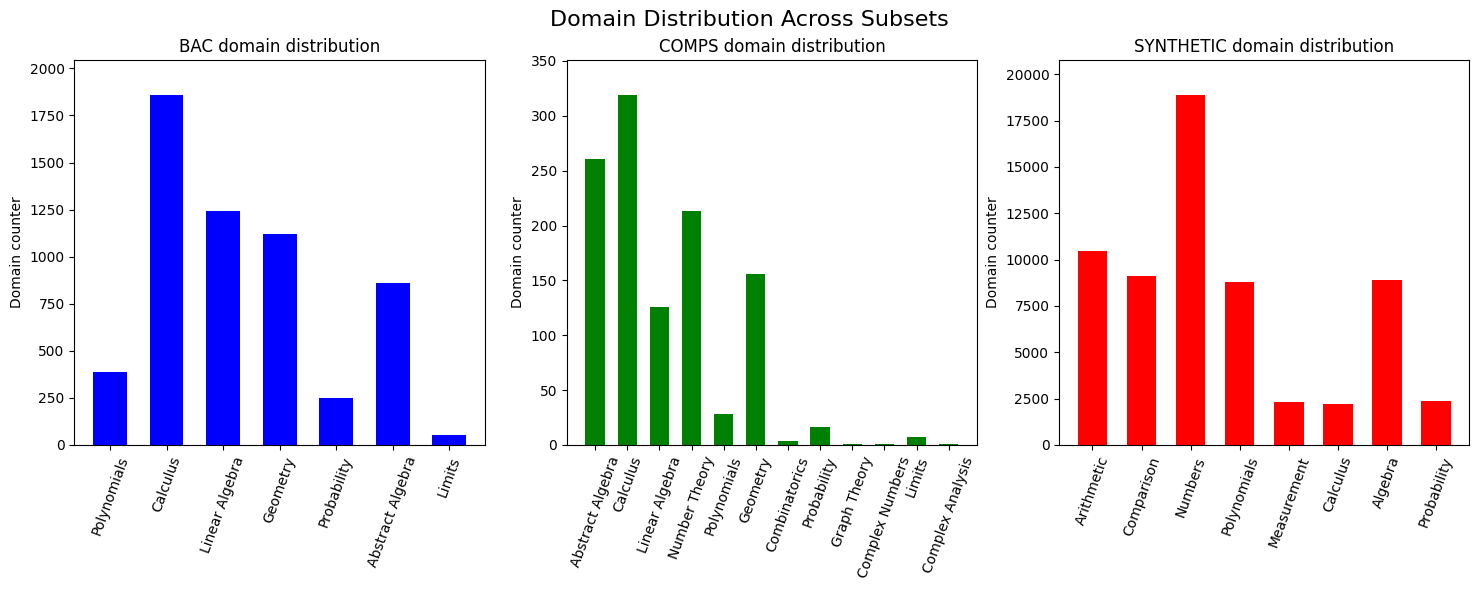

In [163]:
dataset_visualizer = DatasetVisualizer(ro_math_bac_set_combined, ro_math_comp_set_combined, ro_math_synthethic_set_combined)
dataset_visualizer.visualize_domain_distributions()

In [ ]:
# TODO: Start finetuning the model